<a href="https://colab.research.google.com/github/Alina9/DUL/blob/hw3.2/Homework_3_2_Latent_Variable_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 35.86 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
--2020-12-09 15:53:38--  https://docs.google.com/uc?export=download&confirm=iKEi&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 172.217.8.14, 2607:f8b0:4004:807::200e
Connecting to docs.google.com (docs.google.com)|172.217.8.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-58-docs.googleusercontent.com/docs/securesc/m7c0f48i311bt758ho0gnlhsa37om1l2/8jgrha5535j2ifoe1ushr1e94da8bgq8/1607529150000/06419056966375271799/08959275588365015681Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-12-09 15:53:38--  https://doc-

In [2]:
from deepul.hw3_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


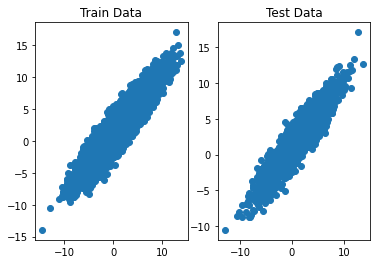

Dataset 2


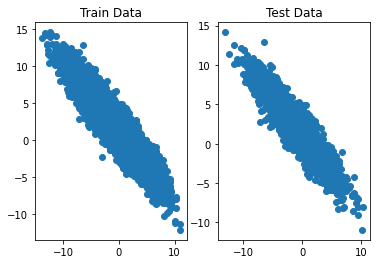

In [3]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




In [4]:
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, train_loader, test_loader,  optimizer, epoch):
  train_losses = []
  test_losses = []
  for e in range(epoch):
    model.train()    
    epoch_losses = []
    for x in train_loader:
      x = x.to(device).float().contiguous()
      rec, kl = model.loss(x)
      loss = rec+kl
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_losses.append([loss.item(), rec.item(), kl.item()])
    train_losses.extend(epoch_losses)

    # test
    test_rec, test_kl = eval_loss(model, test_loader)
    test_loss = test_rec + test_kl
    test_losses.append([test_loss, test_rec, test_kl])
    if e%10 == 0:
      print(f'Epoch {e}, Test loss {test_loss}')
  return train_losses, test_losses

def eval_loss(model, data_loader):
  model.eval()
  total_rec, total_kl = 0, 0
  with torch.no_grad():
    for x in data_loader:
      x = x.to(device).float().contiguous()
      rec, kl = model.loss(x)
      total_rec += rec.item() * x.shape[0]
      total_kl += kl.item() * x.shape[0]
  return total_rec / len(data_loader.dataset), total_kl / len(data_loader.dataset)

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
from torch.distributions.normal import Normal

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    output = self.relu(self.linear1(x))
    output = self.relu(self.linear2(output))
    output = self.linear3(output)
    return output

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, input_size, latent_size, hidden_size1, hidden_size2):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.input_size = input_size
    self.encoder = MLP(input_size, hidden_size1, 2*latent_size)
    self.decoder = MLP(latent_size, hidden_size2, 2*input_size)
  
  def forward(self, x):
    moments_z = self.encoder(x)
    mu_z, log_s_z = moments_z[:, :self.latent_size], moments_z[:, self.latent_size:]
    z = torch.randn_like(mu_z)*(log_s_z.exp())+mu_z

    moments_x = self.decoder(z)
    mu_x, log_s_x = moments_x[:, :self.input_size], moments_x[:, self.input_size:]
    return mu_z, log_s_z, z, mu_x, log_s_x

  def loss(self, x):
    mu_z, log_s_z, z, mu_x, log_s_x= self.forward(x)

    norm = Normal(mu_x, log_s_x.exp())
    reconstruction_loss = -(norm.log_prob(x)).sum(1).mean()

    KL_loss = -log_s_z - 0.5 + ((2 * log_s_z).exp() + mu_z ** 2) * 0.5
    KL_loss = KL_loss.sum(1).mean()
    return reconstruction_loss, KL_loss

  def sample(self, n_samples, noise=True):
    with torch.no_grad():
      z = torch.randn(n_samples, self.latent_size)
      moments_x = self.decoder(z.to(device))
      mu_x, log_s_x = moments_x[:, :self.input_size], moments_x[:, self.input_size:]
      if noise:
        x = torch.randn_like(mu_x) * log_s_x.exp() + mu_x
      else:
        x = mu_x
    return x.cpu().numpy()
    

In [ ]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """ 
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)

    model = VAE(2, 2, 128, 128).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_losses, test_losses = train(model, train_loader, test_loader,  optimizer, epoch = 20)

    samples_noise = model.sample(1000, noise=True)
    samples_without_noise = model.sample(1000, noise=False)

    return np.array(train_losses), np.array(test_losses), samples_noise, samples_without_noise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Epoch 0, Test loss 5.447459580636025
Epoch 10, Test loss 4.456526140975952
Final -ELBO: 4.4543, Recon Loss: 2.8539, KL Loss: 1.6004


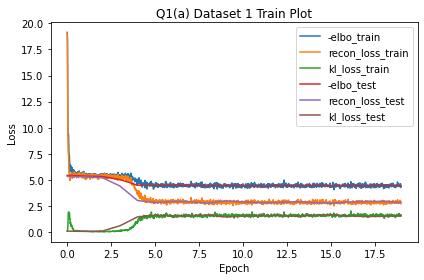

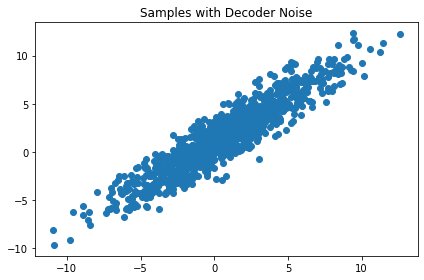

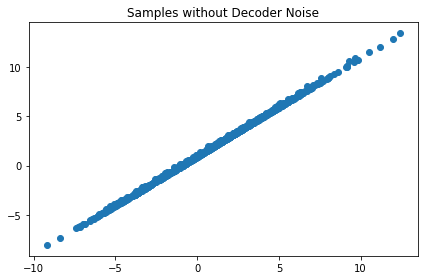

In [ ]:
q1_save_results('a', 1, q1)

Epoch 0, Test loss 5.365099604964256
Epoch 10, Test loss 4.423851311683655
Final -ELBO: 4.4459, Recon Loss: 2.8555, KL Loss: 1.5904


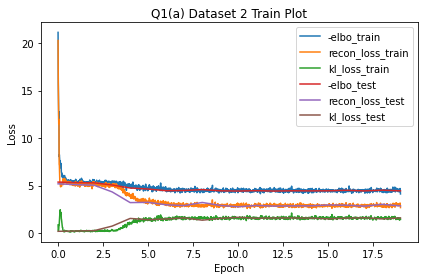

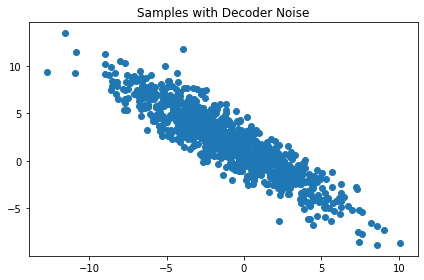

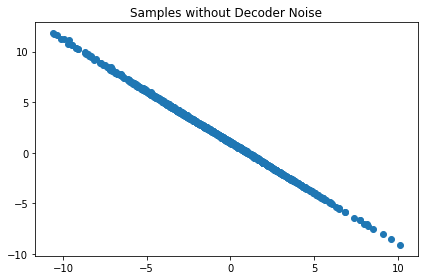

In [ ]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


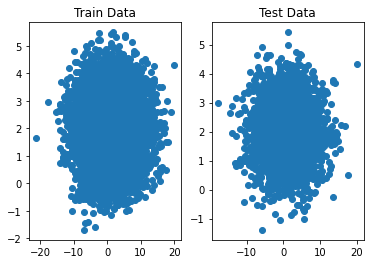

Dataset 2


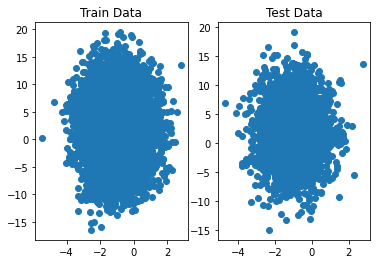

In [ ]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Epoch 0, Test loss 4.519426486191153
Epoch 10, Test loss 4.429123506610096
Final -ELBO: 4.4246, Recon Loss: 4.4180, KL Loss: 0.0066


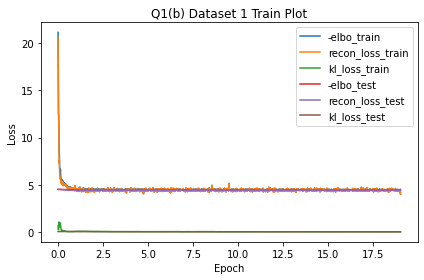

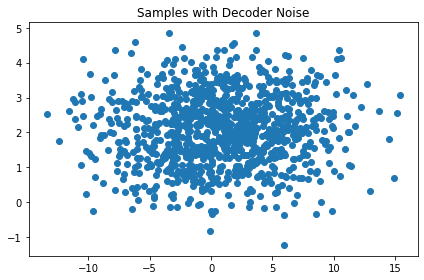

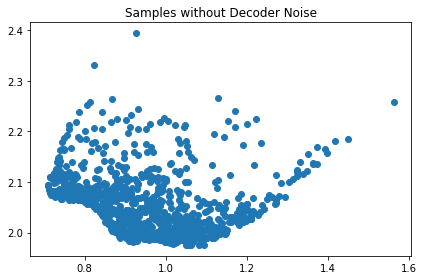

In [ ]:
q1_save_results('b', 1, q1)

Epoch 0, Test loss 4.483778162938357
Epoch 10, Test loss 4.423690974249691
Final -ELBO: 4.4242, Recon Loss: 4.4147, KL Loss: 0.0095


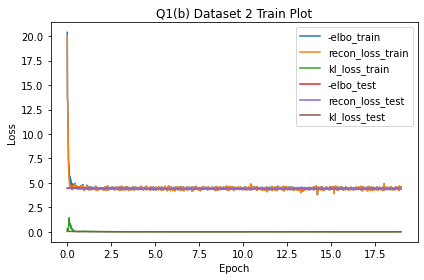

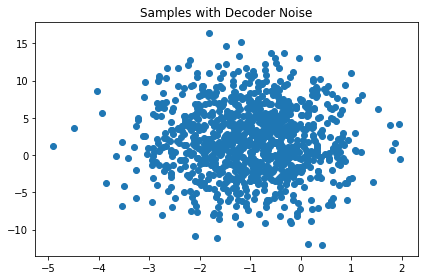

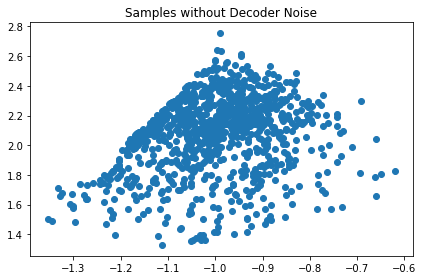

In [ ]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without decoder noise in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

В (b) данные имеют диагональную ковариационную матрицу. Это видно по самим данным. Поэтому декодер, который является гауссовским распределением с диагональной ковариационной матрицей, может достаточно точно моделировать данные.

В (a) данные имеют не диагональную ковариационную матрицу. 
Поэтому мы не можем приблизить данные с помощью гауссовского распределения с диагональной ковариационной матрицей. И вклад mu_x играет большую роль 

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

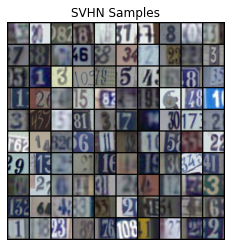

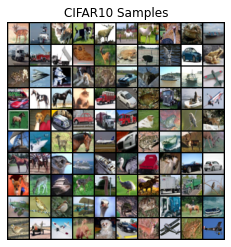

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_shape, latent_size):
    super(Encoder, self).__init__()
    self.input_shape = input_shape
    self.latent_size = latent_size
    self.conv1 = nn.Conv2d(self.input_shape[0], 32, 3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
    self.relu = nn.ReLU()
    self.linear = nn.Linear(input_shape[1] // 8 * self.input_shape[2] // 8 * 256, 2 * latent_size)

  def forward(self, x):
    output = self.relu(self.conv1(x))
    output = self.relu(self.conv2(output))
    output = self.relu(self.conv3(output))
    output = self.relu(self.conv4(output))
    output = output.view(output.shape[0], -1)
    output = self.linear(output)
    mu, log_s  = output[:, :self.latent_size], output[:, self.latent_size:]
    return mu, log_s  

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_size, output_shape):
    super(Decoder, self).__init__()
    self.output_shape = output_shape
    self.latent_size = latent_size
    self.linear = nn.Linear(latent_size, 128*self.output_shape[1] // 8*self.output_shape[2] // 8)
    self.conv1 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
    self.conv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
    self.conv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
    self.conv4 = nn.Conv2d(32, output_shape[0], 3, padding=1)
    self.relu = nn.ReLU()      

  def forward(self, x):
    output = self.relu(self.linear(x))
    output = output.view(output.shape[0], 128, self.output_shape[1] // 8, self.output_shape[2] // 8)
    output = self.relu(self.conv1(output))
    output = self.relu(self.conv2(output))
    output = self.relu(self.conv3(output))
    output = self.conv4(output)        
    return output

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, input_shape, latent_size):
    super(VAE, self).__init__()
    self.input_shape = input_shape
    self.latent_size = latent_size
    self.encoder = Encoder(input_shape, latent_size)
    self.decoder = Decoder(latent_size, input_shape)
  
  def forward(self, x):
    mu_z, log_s_z = self.encoder(x)
    z = torch.randn_like(mu_z)*(log_s_z.exp())+mu_z
    mu_x = self.decoder(z)
    return mu_z, log_s_z, z, mu_x

  def loss(self, x):
    mu_z, log_s_z, z, mu_x = self.forward(x)

    #norm = Normal(mu_x, 1)
    #reconstruction_loss = -(norm.log_prob(x)).sum(1).mean()
    reconstruction_loss = ((mu_x - x)**2).view(x.shape[0], -1).sum(1).mean()

    KL_loss = -log_s_z - 0.5 + ((2 * log_s_z).exp() + mu_z ** 2) * 0.5
    KL_loss = KL_loss.sum(1).mean()
    return reconstruction_loss, KL_loss

  def sample(self, n_samples, noise=True):
    with torch.no_grad():
      z = torch.randn(n_samples, self.latent_size)
      mu_x = self.decoder(z.to(device))
      if noise:
        x = torch.randn_like(mu_x) + mu_x
      else:
        x = mu_x
      x = torch.clamp(x, 0, 1)
    return 255*x.permute(0, 2, 3, 1).cpu().numpy()

  def reconstructions(self, data):
    with torch.no_grad():
      data = torch.tensor(data).to(device).float().contiguous()
      mu_z, log_s_z = self.encoder(data)
      mu_x = self.decoder(mu_z.to(device))
      x_rec = torch.clamp(mu_x, 0, 1)
      res = torch.stack((data, x_rec), dim=1).view(-1, 3, 32, 32)
      res = 255*res.permute(0, 2, 3, 1).cpu().numpy()
    return res
  
  def interpolation(self, data):
    batch_size = data.shape[0]
    with torch.no_grad():
      data = torch.tensor(data).to(device).float().contiguous()
      z, _ = self.encoder(data)
      z1, z2 = z[:batch_size//2], z[batch_size//2:]
      res = [self.decoder(z1 * (1 - a) + z2 * a) for a in np.linspace(0, 1, 10)]
      res = torch.stack(res, dim=1).view(-1, 3, 32, 32)
      res = torch.clamp(res, 0, 1)
      res = 255*res.permute(0, 2, 3, 1).cpu().numpy()
      return res    

In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255. ).astype('float32')

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)

    model = VAE((3, 32, 32), 16).to(device)

    optimizer = optim.Adam(model.parameters(), lr=7e-4)
    train_losses, test_losses = train(model, train_loader, test_loader,  optimizer, epoch = 30)

    samples_noise = model.sample(100, noise=False)
    recs = model.reconstructions(test_data[:50])
    ints = model.interpolation(test_data[:20])

    return np.array(train_losses), np.array(test_losses), samples_noise, recs, ints

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('a', 1, q2_a)

In [ ]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class MaskedLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias=False):
    super(MaskedLinear, self).__init__(in_features, out_features, bias)
    self.register_buffer('mask', torch.ones(out_features, in_features))

  def set_mask(self, mask):
    self.mask.data.copy_(mask)

  def forward(self, input):
    return F.linear(input, self.mask * self.weight, self.bias)

In [ ]:
class Made(torch.nn.Module):
  def __init__(self, d, input_shape, hidden_size, one_hot_inputs = False):
    super(Made, self).__init__()
    self.d = d
    self.input_shape = input_shape
    self.input_size = np.prod(input_shape)
    self.one_hot_inputs = one_hot_inputs
    self.hidden_size = hidden_size
    self.masked_matrix_list = self.make_mask()
    self.fc1 = MaskedLinear(self.input_size*d, hidden_size) if one_hot_inputs else MaskedLinear(self.input_size, hidden_size)
    self.fc1.set_mask(self.masked_matrix_list[0])
    self.fc2 = MaskedLinear(hidden_size, hidden_size)
    self.fc2.set_mask(self.masked_matrix_list[1])
    self.fc3 = MaskedLinear(hidden_size, self.input_size*d)
    self.fc3.set_mask(self.masked_matrix_list[2])
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()    

  def make_mask(self):
    m0 = np.arange(self.input_size)
    if self.one_hot_inputs:
      m0 = np.repeat(m0, self.d)
    m1 = np.random.randint(low=m0.min(), high=self.input_size-1, size=self.hidden_size)
    m2 = np.random.randint(low=m1.min(), high=self.input_size-1, size=self.hidden_size)
    m3 = np.repeat(np.arange(self.input_size), self.d)

    M1 = torch.from_numpy((m1[:, None] >= m0[None, :]).astype(np.uint8))
    M2 = torch.from_numpy((m2[:, None] >= m1[None, :]).astype(np.uint8))
    M3 = torch.from_numpy((m3[:, None] > m2[None, :]).astype(np.uint8))
    masked_matrices = [M1, M2, M3]
    return masked_matrices

  def forward(self, x):
    batch_size = x.shape[0]
    if self.one_hot_inputs:
      x = one_hot(x, self.d)
    else:
      x = x.reshape(batch_size, self.input_size)
    x = x.to(device).float()
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    output = self.fc3(x).reshape(batch_size, self.input_size, self.d)
    return output


In [ ]:
class VLAE(torch.nn.Module):
  def __init__(self, input_shape, latent_size):
    super(VLAE, self).__init__()
    self.input_shape = input_shape
    self.latent_size = latent_size

    self.made = Made(2, latent_size, hidden_size = 512)
    self.encoder = Encoder(input_shape, latent_size)
    self.decoder = Decoder(latent_size, input_shape)
  
  def loss(self, x):
    mu_z, log_s_z = self.encoder(x)
    z = torch.randn_like(mu_z)*(log_s_z.exp()) + mu_z

    z_log_prob = -log_s_z - 0.5 * (z - mu_z) ** 2 *(-2 * log_s_z).exp()

    made_out = self.made(z)
    mu, log_s = made_out[...,0], made_out[...,1]
    mu, log_std = mu.squeeze(-1), log_s.squeeze(-1)
    eps = z * log_s.exp() + mu
    prior_log_prob = log_std - 0.5 * eps ** 2
    KL_loss = (z_log_prob - prior_log_prob).sum(1).mean()

    mu_x = self.decoder(z)
    reconstruction_loss = ((mu_x - x)**2).view(x.shape[0], -1).sum(1).mean()
    return reconstruction_loss, KL_loss


  def sample(self, n_samples):
    with torch.no_grad():
      z = torch.randn(n_samples, self.latent_size).to(device)
      made_output = self.made(z)
      for i in range(self.latent_size):
        made_i = made_output[:, i]
        mu, log_s = made_i[...,0], made_i[...,1]
        mu, log_s = mu.squeeze(-1), log_s.squeeze(-1)
        z[:, i] = (z[:, i] - mu) * (-log_s).exp()
      mu_x = self.decoder(z)
      res = torch.clamp(mu_x, 0, 1)
    return 255*res.permute(0, 2, 3, 1).cpu().numpy()

  def reconstructions(self, data):
    with torch.no_grad():
      data = torch.tensor(data).to(device).float().contiguous()
      mu_z, log_s_z = self.encoder(data)
      mu_x = self.decoder(mu_z.to(device))
      x_rec = torch.clamp(mu_x, 0, 1)
      res = torch.stack((data, x_rec), dim=1).view(-1, 3, 32, 32)
      res = 255*res.permute(0, 2, 3, 1).cpu().numpy()
    return res
  
  def interpolation(self, data):
    batch_size = data.shape[0]
    with torch.no_grad():
      data = torch.tensor(data).to(device).float().contiguous()
      z, _ = self.encoder(data)
      z1, z2 = z[:batch_size//2], z[batch_size//2:]
      res = [self.decoder(z1 * (1 - a) + z2 * a) for a in np.linspace(0, 1, 10)]
      res = torch.stack(res, dim=1).view(-1, 3, 32, 32)
      res = torch.clamp(res, 0, 1)
      res = 255*res.permute(0, 2, 3, 1).cpu().numpy()
      return res    

In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)

    model = VLAE((3, 32, 32), 16).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_losses, test_losses = train(model, train_loader, test_loader,  optimizer, epoch = 30)

    samples_noise = model.sample(100)
    recs = model.reconstructions(test_data[:50])
    ints = model.interpolation(test_data[:20])

    return np.array(train_losses), np.array(test_losses), samples_noise, recs, ints

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

VQ-VAE

In [6]:
class ResidualBlock(nn.Module):
  def __init__(self, dim):
    super(ResidualBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(dim)
    self.conv1 = nn.Conv2d(dim, dim, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(dim)
    self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)
    self.relu = nn.ReLU()


  def forward(self, x):
    output = self.conv1(self.relu(self.bn1(x)))
    output = self.conv2(self.relu(self.bn2(output)))
    return output + x

In [7]:
class Encoder(nn.Module):
  def __init__(self, dim):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(3, dim, 4, 2, 1)
    self.bn = nn.BatchNorm2d(dim)
    self.conv2 = nn.Conv2d(dim, dim, 4, 2, 1)
    self.res_block1  = ResidualBlock(dim)
    self.res_block2  = ResidualBlock(dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    output = self.relu(self.bn(self.conv1(x)))
    output = self.res_block1(self.conv2(output))
    output = self.res_block2(output)
    return output

In [56]:
class Decoder(nn.Module):
  def __init__(self, dim):
    super(Decoder, self).__init__()
    self.res_block1  = ResidualBlock(dim)
    self.res_block2  = ResidualBlock(dim)
    self.bn1 = nn.BatchNorm2d(dim)
    self.conv1 = nn.ConvTranspose2d(dim, dim, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(dim)
    self.conv2 = nn.ConvTranspose2d(dim, 3, 4, 2, 1)    
    self.relu = nn.ReLU()
    self.act_fn = nn.Sigmoid()

  def forward(self, x):
    output = self.res_block1(x)
    output = self.res_block2(output)
    output = self.conv1(self.bn1(self.relu(output)))
    output = self.conv2(self.bn2(self.relu(output)))
    return self.act_fn(output)

In [9]:
class CodeBook(nn.Module):
  def __init__(self, K, D):
    super(CodeBook, self).__init__()
    self.K = K
    self.D = D
    self.embeddings = nn.Parameter((2 * torch.rand(K, D) - 1.) / K)

  def forward(self, z):
    n, c, h, w = z.shape
    flat_z = z.permute(0, 2, 3, 1).contiguous().view(-1, self.D).unsqueeze(0)
    dist = torch.cdist(flat_z, self.embeddings.unsqueeze(0)).squeeze()

    _, idx = torch.min(dist, 1)
    idx = idx.view(n, h, w)
    e_k = self.embeddings[idx].permute(0, 3, 1, 2).contiguous()

    return e_k, idx

In [10]:
class VQVAE(nn.Module):
  def __init__(self, K, D):
    super(VQVAE, self).__init__()
    self.K = K
    self.D = D

    self.encoder = Encoder(D)
    self.codebook = CodeBook(K, D)
    self.decoder = Decoder(D)
  
  def forward(self, x):
    z = self.encoder(x)
    e, idx = self.codebook(z)
    rec_x = self.decoder((e - z).detach() + z)

    vq_loss = torch.mean((z.detach() - e)**2)
    commitment_loss = torch.mean((e.detach() - z)**2)
    rec_loss = torch.mean((x - rec_x)**2)
    return rec_x, vq_loss, commitment_loss, rec_loss

  def loss(self, x):
    rec_x, vq_loss, commitment_loss, rec_loss = self.forward(x)
    return vq_loss + commitment_loss + rec_loss

  def encode(self, x):
    res = []
    loader = torch.utils.data.DataLoader(x, batch_size=256)
    self.eval()
    with torch.no_grad():
      for batch in loader:
        z = self.encoder(batch.float().to(device))
        e, idx = self.codebook(z)
        res.append(idx.long())        
    return torch.cat(res)

  def decode(self, idx):
    self.eval()
    with torch.no_grad():
      e = self.codebook.embeddings[idx].permute(0, 3, 1, 2)
      x = self.decoder(e)
    return x.permute(0, 2, 3, 1).cpu().detach().numpy()

PixelCNN

In [11]:
class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(MaskConv2d, self).__init__(*args, **kwargs)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def forward(self, input):
    batch_size = input.shape[0]
    output = F.conv2d(input, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)
    return output

  def create_mask(self, mask_type):
    h, w = self.kernel_size
    if mask_type == 'A':     
      self.mask[:, :, h // 2, :w // 2] = 1
      self.mask[:, :, :h // 2] = 1
    if mask_type == 'B':
      self.mask[:, :, h // 2, :w // 2 + 1] = 1
      self.mask[:, :, :h // 2] = 1

In [12]:
class ResidualPixelCNN(nn.Module):
  def __init__(self, dim):
    super(ResidualPixelCNN, self).__init__()
    self.ln1 = nn.LayerNorm(dim)
    self.relu = nn.ReLU()
    self.conv1 = MaskConv2d('B', dim, dim//2, 1)
    self.ln2 = nn.LayerNorm(dim//2)
    self.conv2 = MaskConv2d('B', dim // 2, dim // 2, 3, 1, 1)
    self.ln3 = nn.LayerNorm(dim//2)
    self.conv3 = MaskConv2d('B', dim // 2, dim, 1)
  
  def ln(self, fn, x):
    output = fn(x.permute(0, 2, 3, 1).contiguous())
    return output.permute(0, 3, 1, 2).contiguous()

  def forward(self, x):
    output = self.conv1(self.relu(self.ln(self.ln1, x)))
    output = self.conv2(self.relu(self.ln(self.ln2, output)))
    output = self.conv3(self.relu(self.ln(self.ln3, output)))
    return output
    

In [81]:
class PixelCNN(nn.Module):
  def __init__(self, input_shape, K, D):
    super(PixelCNN, self).__init__()
    self.input_shape = input_shape
    self.K = K
    self.D = D
    self.embedding = nn.Embedding(K, D)
    self.convA = MaskConv2d('A', D, D, 7, 1, 3)
    self.ln1 = nn.LayerNorm(D)
    self.res_blocks = nn.ModuleList([ResidualPixelCNN(D) for i in range(6)]) 
    self.ln2 = nn.LayerNorm(D)
    self.convB1 = MaskConv2d('B', D, 2*D, 1)
    self.convB2 = MaskConv2d('B', 2*D, K, 1)
    self.relu = nn.ReLU()

  def ln(self, fn, x):
    output = fn(x.permute(0, 2, 3, 1).contiguous())
    return output.permute(0, 3, 1, 2).contiguous()

  def forward(self, x):
    output = self.embedding(x).permute(0, 3, 1, 2).contiguous()
    output = self.convA(output)
    output = self.relu(self.ln(self.ln1, output))
    for i in range(6):
      output = self.res_blocks[i](output)
    output = self.relu(self.ln(self.ln2, output))
    output = self.relu(self.convB1(output))
    output = self.convB2(output)
    return output

  def loss(self, x):
    res = self.forward(x.long())
    return F.cross_entropy(res, x.long())

  def sample(self, n):
    self.eval()
    with torch.no_grad():
      samples = torch.zeros(n, *self.input_shape).to(device).long()
      for x in range(self.input_shape[0]):
        for y in range(self.input_shape[1]):
          logits = self.forward(samples)[:, :, x, y]
          prob = F.softmax(logits, dim=1)
          samples[:, x, y] = torch.multinomial(prob, 1)[...,0]
    return samples  


In [14]:
def train(model, train_loader, test_loader,  optimizer, epoch):
  train_losses = []
  test_losses = []
  for e in range(epoch):
    model.train()    
    epoch_losses = []
    for x in train_loader:
      x = x.to(device).float().contiguous()
      loss = model.loss(x)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_losses.append(loss.item())
    train_losses.extend(epoch_losses)

    # test
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if e%1 == 0:
      print(f'Epoch {e}, Test loss {test_loss}')
  return train_losses, test_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.to(device).float().contiguous()
      loss = model.loss(x)
      total_loss += loss.item() * x.shape[0]
  return total_loss / len(data_loader.dataset)

In [77]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')
    K, D = 128, 256

    # VQ-VAE
    print("VQ-VAE")
    train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=256)

    vqvae = VQVAE(K, D).to(device)
    vqvae.train()

    optimizer = optim.Adam(vqvae.parameters(), lr=1e-3)
    vq_train_losses, vq_test_losses = train(vqvae, train_loader, test_loader,  optimizer, epoch = 20)

    train_encoded = vqvae.encode(train_data)
    test_encoded  = vqvae.encode(test_data)

    # PixelCNN
    print()
    print("PixelCNN")
    prior_train_loader = data.DataLoader(train_encoded, batch_size=256, shuffle=True)
    prior_test_loader = data.DataLoader(test_encoded, batch_size=256)

    pixelcnn = PixelCNN((8, 8), K, D).to(device)
    pixelcnn.train()

    optimizer = optim.Adam(pixelcnn.parameters(), lr=1e-3)
    cnn_train_losses, cnn_test_losses = train(pixelcnn, prior_train_loader, prior_test_loader,  optimizer, epoch = 40)


    samples = pixelcnn.sample(100)
    samples = 255*vqvae.decode(samples)

    # reconstruction
    x = test_data[:50]
    z = vqvae.encode(x)    
    rec_x = vqvae.decode(z)
    x = x.transpose(0, 2, 3, 1)
    rec = np.stack((x, rec_x ), axis=1).reshape((-1, 32, 32, 3)) * 255

    return vq_train_losses, vq_test_losses, cnn_train_losses, cnn_test_losses, samples, rec


## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

VQ-VAE
Epoch 0, Test loss 62.04400635375976
Epoch 1, Test loss 2.2705435230255127
Epoch 2, Test loss 0.5243676918506622
Epoch 3, Test loss 0.8365536057472229
Epoch 4, Test loss 0.19307031183242798
Epoch 5, Test loss 0.12922220128774642
Epoch 6, Test loss 0.10689720591306687
Epoch 7, Test loss 0.08324650127887726
Epoch 8, Test loss 0.07321466571092605
Epoch 9, Test loss 0.05848371986150742
Epoch 10, Test loss 0.05072868275642395
Epoch 11, Test loss 4.142017601394653
Epoch 12, Test loss 0.13926975815296172
Epoch 13, Test loss 0.1062912703871727
Epoch 14, Test loss 0.04840427508950233
Epoch 15, Test loss 0.04617460316419601
Epoch 16, Test loss 0.038312053906917574
Epoch 17, Test loss 0.03578448298573494
Epoch 18, Test loss 0.04022713268995285
Epoch 19, Test loss 0.03283837889432907

PixelCNN
Epoch 0, Test loss 3.441885580444336
Epoch 1, Test loss 3.3927913410186767
Epoch 2, Test loss 3.39957751121521
Epoch 3, Test loss 3.023106661605835
Epoch 4, Test loss 2.997004549407959
Epoch 5, Test l

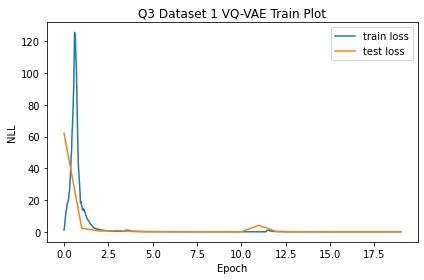

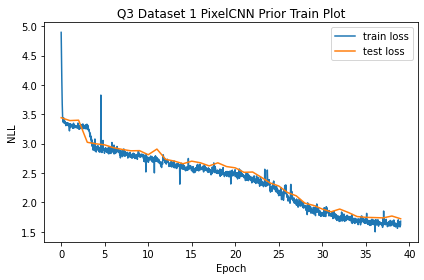

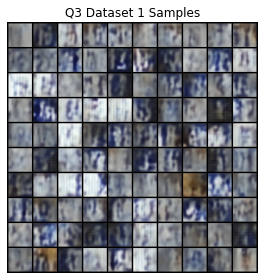

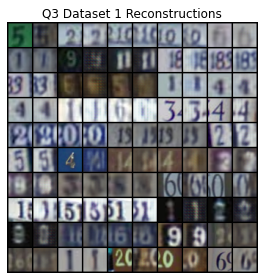

In [78]:
q3_save_results(1, q3)

VQ-VAE
Epoch 0, Test loss 0.12032456080913544
Epoch 1, Test loss 0.05670347175598144
Epoch 2, Test loss 0.03817849065065384
Epoch 3, Test loss 0.030354487681388855
Epoch 4, Test loss 0.02556691893041134
Epoch 5, Test loss 0.022551145887374877
Epoch 6, Test loss 0.020782130908966065
Epoch 7, Test loss 0.01942483755648136
Epoch 8, Test loss 0.017933150270581247
Epoch 9, Test loss 0.017068129652738573
Epoch 10, Test loss 0.016061221981048583
Epoch 11, Test loss 0.026396271497011185
Epoch 12, Test loss 0.014743733727931977
Epoch 13, Test loss 0.01410732150375843
Epoch 14, Test loss 0.014630864104628563
Epoch 15, Test loss 0.013115366299450398
Epoch 16, Test loss 0.012678881701827049
Epoch 17, Test loss 0.01242518043667078
Epoch 18, Test loss 0.01241871623545885
Epoch 19, Test loss 0.01528844847381115

PixelCNN
Epoch 0, Test loss 4.185179692840576
Epoch 1, Test loss 4.139596488952637
Epoch 2, Test loss 4.120766259765625
Epoch 3, Test loss 4.084220627593994
Epoch 4, Test loss 4.0581893066406

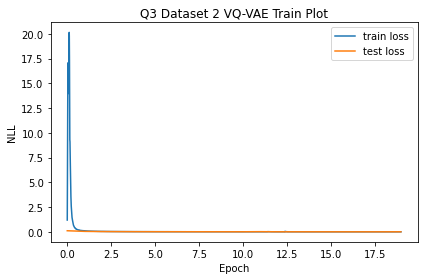

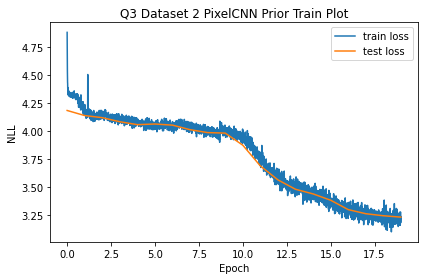

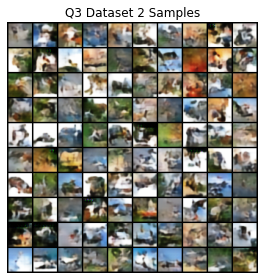

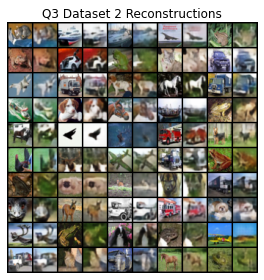

In [36]:
q3_save_results(2, q3)

# Question 4 Bonus [15pts]

## Part (a) Improving VQ-VAE Results [10pts]
Improve upon your results in Q3, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q4_a`, execute the cells below to visualize and save your results.

In [ ]:
q4_a_save_results(2, q4_a)

## Part (b) PixelVAE [5pts]
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `q4_b`, execute the cells below to visualize and save your results

In [ ]:
q4_b_save_results(q4_b)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)